In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb


# load files 

In [3]:
BS = loadmat('D:\\GoogleDrive\\retina\\oled_boundary_set', squeeze_me =True)

exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20210513\\'
direction = 'UD'

SVDnSTK = loadmat(exp_folder+'Analyzed_data\\30Hz_27_RF_15min_re\\unsort\\STK.mat'
                  , squeeze_me =True)
RFprop  = loadmat(exp_folder+'Analyzed_data\\30Hz_27_RF_15min_re\\unsort\\RF_properties.mat'
                  , squeeze_me =True)
BSigma_list = [6.8, 20, 40, 60]
MBExp_list  = [loadmat(exp_folder+'merge\merge_0505_GP_s='+str(BSigma)+'_OUsmooth_1Hz_'+direction+'_6.5v0mW.mat'
                  , squeeze_me =True) for BSigma in BSigma_list]

In [4]:
RFprop = RFprop['RF_properties']

In [5]:
STK = SVDnSTK['gauss_RF']

In [6]:
def Gaussian_filter_2d_Rot(x, y, x0, y0, xs, ys, angle, A):
    cx = x[np.newaxis,:]*np.ones_like(y)[:,np.newaxis]  -x0
    cy = np.ones_like(x)[np.newaxis,:]*y[:,np.newaxis]-y0
    rx =  cx*np.cos(angle) - cy*np.sin(angle) 
    ry =  cx*np.sin(angle) + cy*np.cos(angle)
    return A*(np.exp(-((rx/xs)**2+(ry/ys)**2)/2)),  x-x0, y-y0

In [7]:
cn = 42
dt=1/60.
micro_per_pixel = BS['micro_per_pixel']
RFellipse, xaxis, yaxis = Gaussian_filter_2d_Rot(
                                np.arange(1,801), np.arange(1,601), RFprop[cn-1]['X_Coor'], RFprop[cn-1]['Y_Coor'], 
                                RFprop[cn-1]['X_Width']/1.5/micro_per_pixel, RFprop[cn-1]['Y_Width']/1.5/micro_per_pixel,
                                RFprop[cn-1]['Angle'], RFprop[cn-1]['Amplitude'])

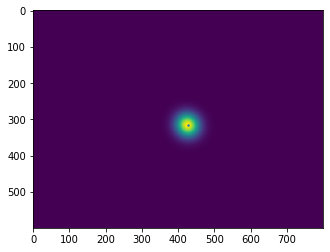

In [8]:
## SVD_SK on display area (whole OLED)
plt.imshow(RFellipse)
plt.scatter(RFprop[cn-1]['X_Coor']-1, RFprop[cn-1]['Y_Coor']-1, s=2)


# conv[SK, Bar]

In [9]:
def Gaussian_filter_1d(x,s):
    return(np.exp(-(x/s)**2/2))

In [10]:
Inten_list = []
for i in range(len(MBExp_list)):
    Inten2u = []
    if direction == 'UD':
        bpu, bpui = np.unique(MBExp_list[i]['bin_pos'], return_inverse=True)
        for bp in bpu:
            bar =  Gaussian_filter_1d((np.arange(1,601)-(bp+300)), BSigma_list[i])
            bar = bar[:, np.newaxis]*np.ones(800)[np.newaxis,:]
            bar[:300-94-1, :] = 0
            bar[300+94:, :] = 0
            bar[:, :400-94-1] = 0
            bar[:, 400+94:] = 0
            Inten2u.append(np.sum(bar*RFellipse))
    Inten_list.append( np.array(Inten2u)[bpui] )

# MI and STA

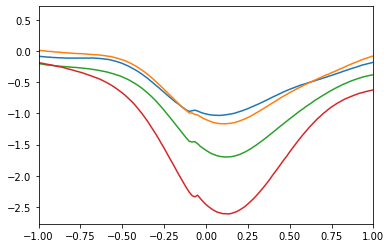

In [18]:
for i in range(len(MBExp_list)):
    x = np.array(Inten_list[i])
    x = (x-np.mean(x))/np.std(x)
    T=np.arange(len(x))*dt+dt
    rstate, _ = np.histogram(MBExp_list[i]['reconstruct_spikes'][cn-1], np.append(0,T))
#     plt.plot(rstate)
    nXcorr = np.correlate(x, rstate, 'same') / np.correlate(np.ones_like(x), rstate, 'same')
    plt.plot(T-T[int(len(T)/2)], nXcorr)
    plt.xlim([-1, 1])

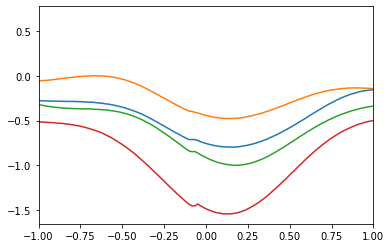

In [16]:
for i in range(len(MBExp_list)):
    x = MBExp_list[i]['bin_pos'].copy()
    x = x.astype(float)
    x = (x-np.mean(x))/np.std(x)
    T=np.arange(len(x))*dt+dt
    rstate, _ = np.histogram(MBExp_list[i]['reconstruct_spikes'][cn-1], np.append(0,T))

    nXcorr = np.correlate(x, rstate, 'same')/np.correlate(np.ones_like(x), rstate, 'same')
    plt.plot(T-T[int(len(T)/2)], nXcorr)
    plt.xlim([-1, 1])